In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
from newer_Galaxy import SpiralGalaxy

INFO: No release version set. Setting default to MPL-7


In [3]:
plt.style.use('seaborn')
plt.style.use('seaborn-colorblind')

In [4]:
usable_paths = np.load('usable_path_list.npy')

In [5]:
gal_objs = [SpiralGalaxy(path) for path in usable_paths]

/homes/sshamsi/.local/lib/python3.5/site-packages/marvin/tools/maps.py:272: MarvinUserWarning: mismatch between file version=DR15 and object release=MPL-7. Setting object release to DR15
  marvin.core.exceptions.MarvinUserWarning)
/homes/sshamsi/.local/lib/python3.5/site-packages/marvin/utils/general/general.py:354: MarvinUserWarning: more than one plate-ifu found for mangaid=1-211017. Using the one with the highest SN2.
  MarvinUserWarning)


In [6]:
mangaid_list = [gal.mangaid for gal in gal_objs]

In [7]:
for gal in gal_objs:
    gal.form_global_df()

In [8]:
for gal in gal_objs:
    gal.df['Mass'] = gal.mass
    
for gal in gal_objs:
    gal.df['$\lg{Mass}$'] = gal.lgmass
    
for gal in gal_objs:
    gal.df['MaNGA ID'] = gal.mangaid

In [9]:
for gal in gal_objs:
    map_ha = gal.maps.getMap('emline_gflux', channel='ha_6564')
    map_hb = gal.maps.getMap('emline_gflux', channel='hb_4862')

    ha_snr = map_ha.snr.flatten()
    hb_snr = map_hb.snr.flatten()

    gal.df['S/N $H_{\\alpha}$'] = ha_snr
    gal.df['S/N $H_{\\beta}$'] = hb_snr

In [10]:
df_list = [gal.df for gal in gal_objs]

spax_df = pd.concat(df_list)

In [11]:
spax_df = spax_df.dropna()
spax_df = spax_df[(spax_df.Comp == 0) & (spax_df.AGN == 0) & (spax_df.Seyfert == 0) & (spax_df.Liner == 0)]
spax_df = spax_df[(spax_df['$r/r_e$'] <= 1) & (spax_df['$r/r_e$'] >= 0.1)]
spax_df = spax_df[(spax_df['S/N $H_{\\alpha}$'] >= 3) & (spax_df['S/N $H_{\\beta}$'] >= 3)]

In [12]:
cut, bins = pd.qcut(spax_df['$\lg{Mass}$'], q=5, retbins=True)

In [13]:
labels = [round((bins[i] + bins[i + 1]) / 2, 2) for i in range(5)]

In [14]:
spax_df['Mass Bin'] = pd.qcut(spax_df['$\lg{Mass}$'], q=5, labels=labels)

In [15]:
def avg_sfr(main_df, mangaid_list, gal_objs):
    ncoor_sfr, ncoor_sfr_var = [], []
    ncoor_sfr_spiral, ncoor_sfr_var_spiral = [], []
    ncoor_sfr_nspiral, ncoor_sfr_var_nspiral = [], []
    
    unique_ids = main_df['MaNGA ID'].unique()
    
    tot_n, tot_n_spiral, tot_n_nspiral = 0, 0, 0
    
    for mangaid in unique_ids:
        df = main_df[main_df['MaNGA ID'] == mangaid]
        df_spiral = df[df['Spiral Arm'] == 1]
        df_nspiral = df[df['Spiral Arm'] == 0]
        
        n = len(df.index)
        n_spiral = len(df_spiral.index)
        n_nspiral = len(df_nspiral.index)
        
        index = mangaid_list.index(mangaid)
        
        if n > 0:
            sfr, sfr_stdv = gal_objs[index].get_sfr(df.index, avg=True)
            
            ncoor_sfr.append(sfr * n)
            ncoor_sfr_var.append((sfr_stdv**2) * n)
            
            tot_n += n
            
        if n_spiral > 0:
            sfr_spiral, sfr_spiral_stdv = gal_objs[index].get_sfr(df_spiral.index, avg=True)
            
            ncoor_sfr_spiral.append(sfr_spiral * n_spiral)
            ncoor_sfr_var_spiral.append((sfr_spiral_stdv**2) * n_spiral)
            
            tot_n_spiral += n_spiral
        
        if n_nspiral > 0:
            sfr_nspiral, sfr_nspiral_stdv = gal_objs[index].get_sfr(df_nspiral.index, avg=True)
            
            ncoor_sfr_nspiral.append(sfr_nspiral * n_nspiral)
            ncoor_sfr_var_nspiral.append((sfr_nspiral_stdv**2) * n_nspiral)
            
            tot_n_nspiral += n_nspiral
        
    tot_sfr = sum(ncoor_sfr) / tot_n
    tot_sfr_stdv = np.sqrt(sum(ncoor_sfr_var) / tot_n)
    
    tot_sfr_spiral = sum(ncoor_sfr_spiral) / tot_n_spiral
    tot_sfr_stdv_spiral = np.sqrt(sum(ncoor_sfr_var_spiral) / tot_n_spiral)
    
    tot_sfr_nspiral = sum(ncoor_sfr_nspiral) / tot_n_nspiral
    tot_sfr_stdv_nspiral = np.sqrt(sum(ncoor_sfr_var_nspiral) / tot_n_nspiral)
    
    return tot_sfr, tot_sfr_stdv, tot_sfr_spiral, tot_sfr_stdv_spiral, tot_sfr_nspiral, tot_sfr_stdv_nspiral

In [16]:
bin_sfrs, bin_sfrs_stdv = [], []
bin_sfrs_spiral, bin_sfrs_stdv_spiral = [], []
bin_sfrs_nspiral, bin_sfrs_stdv_nspiral = [], []

for label in labels:
    df = spax_df[spax_df['Mass Bin'] == label]
    vals = avg_sfr(df, mangaid_list, gal_objs)
    
    bin_sfrs.append(vals[0])
    bin_sfrs_stdv.append(vals[1])
    bin_sfrs_spiral.append(vals[2])
    bin_sfrs_stdv_spiral.append(vals[3])
    bin_sfrs_nspiral.append(vals[4])
    bin_sfrs_stdv_nspiral.append(vals[5])

In [17]:
bin_sfr_spiral_pc = []
bin_sfr_spiral_pc_stdv = []

for i in range(len(labels)):
    sfr_spiral_pc = bin_sfrs_spiral[i] / bin_sfrs[i]
    
    sfr_spiral_pc_stdv = sfr_spiral_pc * np.sqrt((bin_sfrs_stdv_spiral[i] / bin_sfrs_spiral[i])**2 +
                                                 (bin_sfrs_stdv[i]/bin_sfrs[i])**2)
    
    bin_sfr_spiral_pc.append(sfr_spiral_pc)
    bin_sfr_spiral_pc_stdv.append(sfr_spiral_pc_stdv)

(array([0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4]),
 <a list of 9 Text yticklabel objects>)

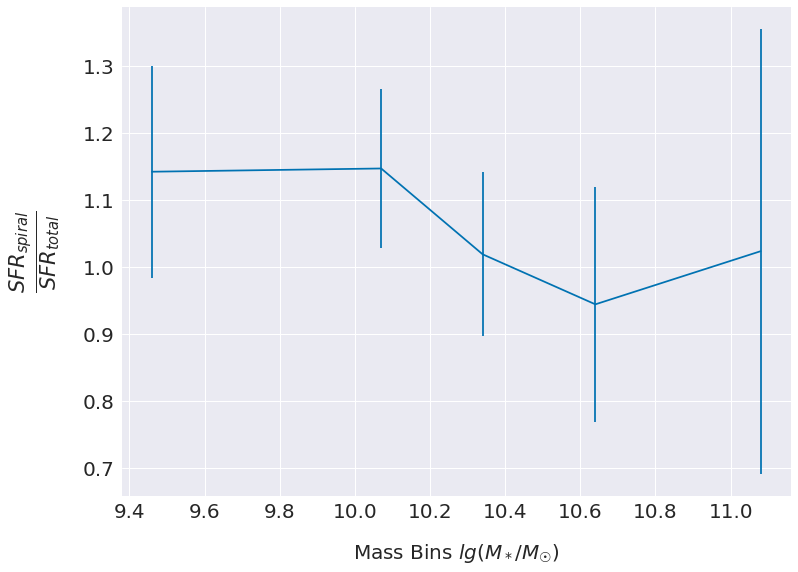

In [21]:
plt.figure(figsize=(12, 9))

plt.errorbar(labels, bin_sfr_spiral_pc, yerr=bin_sfr_spiral_pc_stdv)

plt.xlabel('Mass Bins $lg(M_*/M_☉)$', labelpad=20, size=20)
plt.ylabel(r'$\frac{SFR_{spiral}}{SFR_{total}}$', labelpad=20, size=30)
plt.xticks(size=20)
plt.yticks(size=20)